In [195]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

In [196]:
'''Taken from Prof. Zingale's code'''
class Grid:
    """ a simple class to hold cell-centered finite-difference  /
    finite-volume data """

    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx
        self.ilo = ng
        self.ihi = ng+nx-1

        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.phi = np.zeros((nx+2*ng), dtype=np.float64)

    def scratch_array(self):
        """ return a scratch array dimensioned for our grid """
        return np.zeros((self.nx+2*self.ng), dtype=np.float64)

    def fill_BCs(self):
        """ fill the ghostcells with zero gradient (Neumann)
            boundary conditions """
        self.phi[0:self.ilo] = self.phi[self.ilo]
        self.phi[self.ihi+1:] = self.phi[self.ihi]

    def norm(self, e):
        """ return the norm of quantity e which lives on the grid """
        if not len(e) == (2*self.ng + self.nx):
            return None

        return np.sqrt(self.dx*np.sum(e[self.ilo:self.ihi+1]**2))

In [197]:
def gaussian_ic(g, k, t=0.0, t0=1.e-4, phi1=1.0, phi2=2.0):
    xc = 0.5*(g.xmin + g.xmax)
    return (phi2 - phi1) * (np.sqrt(t0/(t + t0)) * np.exp(-0.25 * (g.x - xc)**2 / (k * (t + t0)))) + phi1

In [198]:
def cn_step(gr, phi, k, dt):
    phinew = gr.scratch_array()
    alpha = k * dt / gr.dx**2

    # create matrix
    R = phi[gr.ilo:gr.ihi+1]
    d = (1.0 + 2.0*alpha)*np.ones(gr.nx)
    u = -alpha*np.ones(gr.nx)
    u[0] = 0.0
    l = -alpha*np.ones(gr.nx)
    l[-1] = 0.0
    d[0] = 1.0 + alpha
    d[-1] = 1.0 + alpha

    A = np.matrix([u, d, l])
    phinew[gr.ilo:gr.ihi+1] = linalg.solve_banded((1, 1), A, R)
    return phinew


In [199]:
def diffuse_crank_nicolson(nx, k, C, tmax, init_cond):
    ng = 1
    g = Grid(nx, ng)
    dt = C * g.dx**2 / (2*k)
    t = 0.0
    g.phi[:] = init_cond(g, k)

    while t < tmax:
        if t + dt > tmax:
            dt = tmax - t
        phinew = cn_step(g, g.phi, k, dt)
        g.phi[:] = phinew[:]
        t += dt
    return g

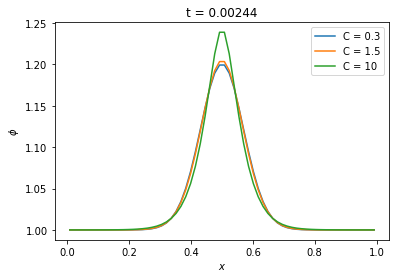

In [200]:
nx = 64
k = 1
t_diffuse = (1.0/nx)**2 / k
fig, ax = plt.subplots()
tmax = 10 * t_diffuse

for C in [0.3, 1.5, 10]:
    g = diffuse_crank_nicolson(nx, k, C, tmax, gaussian_ic)
    ax.plot(g.x[g.ilo:g.ihi+1], g.phi[g.ilo:g.ihi+1], label=f"C = {C}")

ax.set_xlabel("$x$")
ax.set_ylabel("$\phi$")

ax.set_title(f"t = {tmax:7.3g}")
ax.legend()